In [733]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, PowerTransformer, StandardScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

## Task
I have to create some kid of algorith that allows us to determine if given website contains information about 'cancer tumorbaord'. In my opinion the best solution would be to create NLP ML model. I see this as a 3 step task.

* Extract insightful info from various german websites
* Transform raw text to some form of data that could be used to train ML models
* Train, score and tune the best model


## Data cleaning
### In order to train model, we have to remove unessecary text and there is a lot of it
My assumption is that most important information about article will be inside tags: `container, p, article`. So in my approach I will extract text mostly from those tags. Of course some information will be lost in the process, but this step could be optimized in the future without the need of changing the next steps. 


### Functions
Usage is shown below

In [464]:
def get_site_text(url, tags):
    """This function removes all tags provided"""
        
    try:
        with open(url, "r", encoding='utf-8') as file:
            site_raw = file.read()
    except UnicodeDecodeError:
        ## Website has different encoding try old german format
        with open(url, "r", encoding='ISO-8859-1') as file:
            site_raw = file.read()
        
    site = BeautifulSoup(site_raw)
    
    for tag in tags:
        for section in site.find_all(tag):
            section.decompose()
            
    return site.text

def clean_site_text(site_text):
    """Cleans website text form meaningless symbols"""
    clean_text = re.sub("\\n","",site_text)
    clean_text = re.sub("\\t","",clean_text)
    clean_text = re.sub("[0-9]+","",clean_text)
    clean_text = re.sub(" - ","",clean_text)
    clean_text = re.sub("( -|\+|/|\(|\))","",clean_text)
    clean_text = re.sub("(!|\?|\.|,)","",clean_text)
    clean_text = re.sub(" ([a-z]|[A-Z]) ","",clean_text)
    clean_text = re.sub("\s+"," ",clean_text)
        
    return clean_text

def text_to_list(text):
    """Creates list of words from one string containing different words seperated by whitespace"""
    word_list = list(text.split(" "))
    for i in range(len(word_list)):
        word_list[i] = word_list[i].lower()
        
    return word_list

def list_to_counted_dict(word_list):
    """Creates dictionary of words from a 'word_list' with values being the number of their occurances in 'word_list'"""
    
    ## ' -all' is unique key that for sure does not exist in word_list
    words={" -all": len(word_list)}
    
    for word in word_list:
        if word in words:
            words[word]+=1
        else:
            words[word]=1
            
    return words

def create_row(doc_id, word_dict, keyword_list):
    """This function creates dataframe row with information about keyword occurances in text provided from website of given 'doc_id'"""
    
    occurances_dict = dict.fromkeys(keyword_list, [0])
    occurances_dict['doc_id'] = [doc_id]
    
    for keyword in keyword_list:
        if keyword in word_dict:
            occurances_dict[keyword]=[round(word_dict[keyword]/word_dict[' -all'],6)]
    
    return pd.DataFrame.from_dict(occurances_dict)

## Keywords
I want ot check for every website which keywords are used on it and how often.
The idea is that this would give enough information for model, to predict accurately not only if website contains information about tumorbaord, but even the tumor type. 

For this I will use prebuild dataset, maching specific words in german to tumor type.

In [263]:
_keywords = pd.read_csv("keyword2tumor_type.csv")
keywords = list(_keywords['keyword'])


## Process of getting information from website
**From every website with given 'doc_id' I will extract content, but additionally make sure that is does not contain text from unimportant tags**

In [280]:
doc_id = 0

url = f'htmls/{doc_id}.html'
unimportant_tags = ['head','header','script', 'nav', 'footer']


site_text = get_site_text(url, tags)
site_text[0:100]

'\n\n\n\n\n\n\n\n\n\nDie operative Therapie der BauchspeicheldrÃ¼se beziehungsweise ihrer VerÃ¤nderungen ist ei'

**Then I will remove all meaningless characters from it i.e. '\n', ' - '**

In [281]:
clean_text = clean_site_text(site_text)
clean_text[0:100]

'Die operative Therapie der BauchspeicheldrÃ¼se beziehungsweise ihrer VerÃ¤nderungen ist ein besonder'

**Then I transform this one big string into list of words.**

In [268]:
word_list = text_to_list(clean_text)
word_list[0:4]

['die', 'operative', 'therapie', 'der']

**But I want to know how many times they are used on single website, so I count it and make a dict of it**

In [269]:
word_dict=list_to_counted_dict(word_list)
word_dict['radioonkologen']

1

**The last step is to see if any words are from the keyword list and if so, I want to save that information and put it in a row describing this website**

In [270]:
data_row = create_row(doc_id, word_dict, keywords)
data_row

,senologische,brustzentrum,breast,thorax,thorakale,brustkonferenz,rektum,colorec,viszeralchirurgie,visceralonkologischem,...,oral,prätherapeutische,tumore im kindesalter,kinderonkologisches,kinderonkologie,pädiatrische,schwerpunkt,stammzelltransplantation,chirurgisch,doc_id
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## Creating dataset
Function below does it all for every website with `doc_id` inside `id_list`

In [ ]:
def create_dataset(id_list):
    """This function should be used for creating both train and test dataset"""
    
    unimportant_tags = ['head','header','script', 'nav', 'footer']
    
    df = pd.DataFrame()
        
    for doc_id in id_list:

        url = f'htmls/{doc_id}.html'
        site_text = get_site_text(url, unimportant_tags)
        clean_text = clean_site_text(site_text)
        word_list = text_to_list(clean_text)
        word_dict=list_to_counted_dict(word_list)
        data_row = create_row(doc_id, word_dict, keywords)
        
        df = df.append(data_row)
        
    return df
        

### Training dataset instructions

In [209]:
train_instructions = pd.read_csv("train.csv")
train_id_list = list(train_instructions['doc_id'])
y = list(train_instructions['label'])

Just a small peak at the 'train_instructions' dataframe

In [241]:
train_instructions.head()

,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


<AxesSubplot:xlabel='label', ylabel='count'>

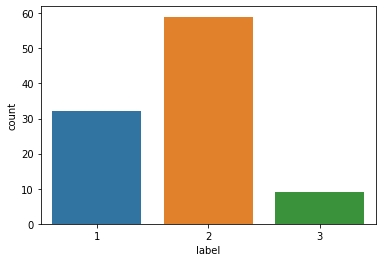

In [240]:
sns.countplot(data = train_instructions, x = 'label')

I just wantetd to tak a look at imbalance of target, and as we can see this dataset is a bit unbalanced. This is not a problem, but will have an inpact on the metrics that we will choose. 

In [703]:
X = create_dataset(train_id_list)

## Let's inspect this dataset

In [685]:
X.describe()

,senologische,brustzentrum,breast,thorax,thorakale,brustkonferenz,rektum,colorec,viszeralchirurgie,visceralonkologischem,...,oral,prätherapeutische,tumore im kindesalter,kinderonkologisches,kinderonkologie,pädiatrische,schwerpunkt,stammzelltransplantation,chirurgisch,doc_id
count,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.000000,100.0,...,100.0,100.0,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.0,0.001094,0.000290,0.000005,0.0,0.0,0.0,0.0,0.000604,0.0,...,0.0,0.0,0.0,0.000013,0.0,0.000076,0.000303,0.000027,0.000011,74.290000
std,0.0,0.003111,0.002768,0.000051,0.0,0.0,0.0,0.0,0.001859,0.0,...,0.0,0.0,0.0,0.000132,0.0,0.000639,0.000797,0.000204,0.000113,44.431151
min,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,32.250000
50%,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,79.500000
75%,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,112.500000
max,0.0,0.019048,0.027664,0.000512,0.0,0.0,0.0,0.0,0.013333,0.0,...,0.0,0.0,0.0,0.001325,0.0,0.006329,0.003759,0.001890,0.001133,146.000000


### Removing unnecessary columns
Columns with only zeros do not provide any information

In [311]:
def remove_empty_cols(data):
    for column in data.columns:
        if data[column].sum() == 0:
            data = data.drop(labels=column, axis=1)
    return data

In [704]:
X = remove_empty_cols(X)

This is far from perfect extraction of data from websites and It could be done in verious of different methods. But I will show that this approach is sufficient for this task.

## Let ML begin

In [715]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.3, random_state=0)

## Algorithms
I decided to try out two classifiers. RandomForest and Support Vector Classifier. The first one because it's handles well almost any kind of data with generally great resoults and doesn't require much training time. And the second because I believe that distanced based approach could work really well in this case. Let's see how they perform with default parameters.

### RandomForest

In [721]:
rf = RandomForestClassifier(random_state=0)

In [696]:
rf.fit(X_train,Y_train)

RandomForestClassifier(random_state=0)

In [697]:
Y_predicted = rf.predict(X_test)
Y_predicted

array([1, 2, 1, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 1])

In [698]:
rf.score(X_test,Y_test)

0.7333333333333333

### Support Vector Classifier

In [699]:
clf = SVC()

In [700]:
clf.fit(X_train, Y_train)

SVC()

In [701]:
Y_predicted = clf.predict(X_test)
Y_predicted

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [702]:
clf.score(X_test,Y_test)

0.6333333333333333

#### Notes
As we can see even though score isn't terrible '0.63', this classifier with default settings is unusable. 


## Metrics
Couple of steps ago I mentioned that this dataset is inbalanced. This is important information because some scoring techniques are not made to handle unbalanced datastes, thus they can be misleading. I will use one main scoring method for hyperparameter tuning and 2 support metrics, just to make sure we improved our classifier. 

Multiclass clasiffication on unbalanced dataset discouraged me from using my typical ROC AUC, or Weighted TPR-TNR, but Cohen's Kappa and MCC should perform great in this case.

## Cohen’s Kappa
This is my main matric that I will be using in `RandomizedSearchCV`

In [492]:
cohen_kappa_score(Y_test, Y_predicted)

0.4736842105263158

### Mathews Correlation Coefficient (MCC)

In [493]:
matthews_corrcoef(Y_test,Y_predicted)

0.47810549759985493

### Balanced Accuracy


In [494]:
balanced_accuracy_score(Y_test, Y_predicted)

0.5122807017543859

In [755]:
def score_classifier(classifier, Y_test):
    Y_predicted = classifier.predict(X_test)
    print(Y_predicted)
    
    CK = cohen_kappa_score(Y_test, Y_predicted)
    MCC = matthews_corrcoef(Y_test, Y_predicted)
    BA = balanced_accuracy_score(Y_test, Y_predicted)
    
    print(f"Cohen's Kappa : {CK}")
    print(f"Matthews Corr : {MCC}")
    print(f"Balanced Acc  : {BA}")

In [590]:
score_classifier(rf)

Cohen's Kappa : 0.5419847328244276
Matthews Corr : 0.5671717776884524
Balanced Acc  : 0.5157894736842105


## Troubles with feature engineering
One of the first things that I wanted to do was to scale this dataset, but I was trying a few diffrent scalers with negative result, so I decided not to use them.
Sadly same goes with standarization and normalization.
This is somewhat expected because my dataset is a sparse martix.

### Min-Max Scaling

In [744]:
scaler = StandardScaler()

In [745]:
X_t = pd.DataFrame(scaler.fit_transform(X))

In [746]:
X_t.describe()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.110223e-18,8.021361e-17,1.249001e-17,2.886580e-17,-2.248202e-17,2.303713e-17,7.771561e-17,8.326673e-19,-3.552714e-17,2.275957e-17,...,5.551115e-18,1.021405e-16,2.303713e-17,4.996004e-18,2.248202e-17,-2.026157e-17,6.661338e-17,-4.996004e-18,2.303713e-17,-1.376677e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,...,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,-1.657828e+00
25%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,-9.509497e-01
50%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,1.178508e-01
75%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-7.795665e-02,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,8.643147e-01
max,5.800329e+00,9.938471e+00,9.949874e+00,6.883377e+00,9.949874e+00,9.949874e+00,9.090616e+00,9.700623e+00,5.563348e+00,8.905978e+00,...,4.967837e+00,5.697854e+00,9.685380e+00,8.203259e+00,9.949874e+00,9.830653e+00,4.359889e+00,9.158684e+00,9.949874e+00,1.622089e+00


In [753]:
def test_FE(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.3, random_state=0)
    classifier = RandomForestClassifier(random_state=0)
    classifier.fit(X_train, Y_train)
    score_classifier(classifier,Y_test)

In [756]:
test_FE(X_t, y)

[1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Cohen's Kappa : 0.0
Matthews Corr : 0.0
Balanced Acc  : 0.3333333333333333


c:\users\bartek\pycharmprojects\scraper\venv\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## StandardScaler

In [757]:
scaler = StandardScaler()
X_t = pd.DataFrame(scaler.fit_transform(X))
X_t.describe()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.110223e-18,8.021361e-17,1.249001e-17,2.886580e-17,-2.248202e-17,2.303713e-17,7.771561e-17,8.326673e-19,-3.552714e-17,2.275957e-17,...,5.551115e-18,1.021405e-16,2.303713e-17,4.996004e-18,2.248202e-17,-2.026157e-17,6.661338e-17,-4.996004e-18,2.303713e-17,-1.376677e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,...,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,-1.657828e+00
25%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,-9.509497e-01
50%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-4.852845e-01,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,1.178508e-01
75%,-3.536057e-01,-1.052477e-01,-1.005038e-01,-3.263719e-01,-1.005038e-01,-1.005038e-01,-1.542422e-01,-1.205678e-01,-2.758943e-01,-1.606338e-01,...,-7.795665e-02,-2.089183e-01,-1.210851e-01,-1.463253e-01,-1.005038e-01,-1.195948e-01,-3.822609e-01,-1.321860e-01,-1.005038e-01,8.643147e-01
max,5.800329e+00,9.938471e+00,9.949874e+00,6.883377e+00,9.949874e+00,9.949874e+00,9.090616e+00,9.700623e+00,5.563348e+00,8.905978e+00,...,4.967837e+00,5.697854e+00,9.685380e+00,8.203259e+00,9.949874e+00,9.830653e+00,4.359889e+00,9.158684e+00,9.949874e+00,1.622089e+00


In [758]:
test_FE(X_t,y)

[1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Cohen's Kappa : 0.0
Matthews Corr : 0.0
Balanced Acc  : 0.3333333333333333


c:\users\bartek\pycharmprojects\scraper\venv\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### Normalization

In [759]:
transformer = Normalizer().fit(X)
X_t = pd.DataFrame(transformer.transform(X))
X_t.describe()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
count,100.000000,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,...,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,0.000065,0.000011,1.969230e-07,0.000037,7.133929e-08,8.092857e-07,0.000002,3.205348e-07,0.000009,0.000005,...,0.000012,6.665597e-07,6.204219e-07,0.000013,1.352041e-07,0.000001,0.000012,2.767741e-07,8.092857e-07,9.999999e-01
std,0.000200,0.000106,1.969230e-06,0.000252,7.133929e-07,8.092857e-06,0.000010,2.610395e-06,0.000040,0.000030,...,0.000027,3.093994e-06,5.278386e-06,0.000093,1.352041e-06,0.000011,0.000041,2.167872e-06,8.092857e-06,4.871572e-07
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,9.999953e-01
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000006,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
max,0.001248,0.001064,1.969230e-05,0.002497,7.133929e-06,8.092857e-05,0.000092,2.527778e-05,0.000332,0.000261,...,0.000121,2.054348e-05,5.190351e-05,0.000754,1.352041e-05,0.000111,0.000318,2.054348e-05,8.092857e-05,1.000000e+00


## Now is the time to improve our model

I will be using `RandomizedSearchCV` because this algorith is fast and provides results very close to grid serach, which generally is too time consuming to use. I have to provide it with classifier, scoring function and parameters grid. The outcome of this function should be close to best possible model. 

In [708]:
classifier = RandomForestClassifier(n_jobs=-1, random_state=0)

In [709]:
my_scorer = make_scorer(cohen_kappa_score, greater_is_better=True)

In [710]:
params ={
    "n_estimators": [50,100],
    "criterion": ["gini","entropy"],
    "max_depth" : range(2,15,2),
    "min_samples_split": range(1,6),
    "min_samples_leaf": range(1,4),
    "max_features" : ["auto", "sqrt", "log2"],
}

In [713]:
random=GridSearchCV(estimator=classifier, param_grid=params, scoring=my_scorer, cv=6, n_jobs=-1, verbose=True)

In [714]:
random_result = random.fit(X_train, Y_train)

Fitting 6 folds for each of 1260 candidates, totalling 7560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s


KeyboardInterrupt: 

## Improved model

In [688]:
best_model = random_result.best_estimator_

### Parameters


In [689]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### Performance

In [690]:
score_classifier(best_model)

Cohen's Kappa : -0.18226600985221664
Matthews Corr : -0.24258948651406492
Balanced Acc  : 0.10526315789473684


## Areas for improvement
Those are just a few notes I want to leave at the end of this task. I chose a specific, possibly not the best approach, but I'm quite happy with the result. Nevertheless there is always room for improvement. 



### Filter website data more efficient
    At the begining I made impactful decision to remove some parts of html i.e. footer, nav. This helped me to reduce amount of words that have nothing to do with the topic but I would want to see if simply removing non german words and html tags wouldn't have worked better. 

### Experiment with feature engineering
    Dataset I created was rather specific and most common feature engineering techniques couldn'd even be used on it. But one could collect data defferently, maybe in a more complex way including number of names on site, analizing the complexity of the language used, categorizing the url. These would take extra time to explore and extract, but this has potential of improving the predictions by a great amount. 

### Different models
    NPL can be done in many ways, but It propably shines with deep learning. From my expirience this approach is much more time consuming and I didn't want to risk it, since this task is time limited and my laptop isn't the fastest. But If I had to do this task again, this is propably what I would use. 
